# Simple Harmonic Oscillator

[Source for Hamilton's Equations (Example 5)](https://www.math.unl.edu/~scohn1/8423/cvar7.pdf)

Hamilton's equations gives us $\displaystyle\dot{x} = \frac{p}{m}$ and $\dot{p} = -kq$ where $m$ is mass, $x$ is the displacement from equilibrium of the mass, $k$ is the spring constant and $p$ is the momentum.

To approximate the simple harmonic oscilator equation, we will use the Euler's method which simply uses $ {\displaystyle y_{i+1}=y_{i} + \dot{y_i}dt }$.

Our approximation function takes intial position $(x_0)$, initial moomentum $(p_0)$, time interval $dt$, maximum time $t_{max}$, mass $m$ and spring constant $k$ as inputs. Then it returns the displacement values $x$ for $t \in [0, t_{max}]$.

In [1]:
import numpy as np
import random

# Analytic solution
def harmonic_oscillator_hamiltonian(x_0, p_0, dt, t_max, m, k):
  t = np.arange(0, t_max, dt)
  x = np.zeros(len(t))
  x[0] = x_0
  p = np.zeros(len(t))
  p[0] = p_0

  for i in range(1, len(t)):
    x[i] = x[i - 1] + p[i - 1] * dt / m
    p[i] = p[i - 1] - k * x[i] * dt

  # create a dictionary by mapping t and x
  data_dict = dict(zip(t, x))

  return data_dict

In [2]:
# Set parameters and generate true data
x_0 = 1
p_0 = 0
m = 1
k = 512
dt = 0.0001
t_max = 1.0

true_data = harmonic_oscillator_hamiltonian(x_0, p_0, dt, t_max, m, k)
true_time=list(true_data.keys())

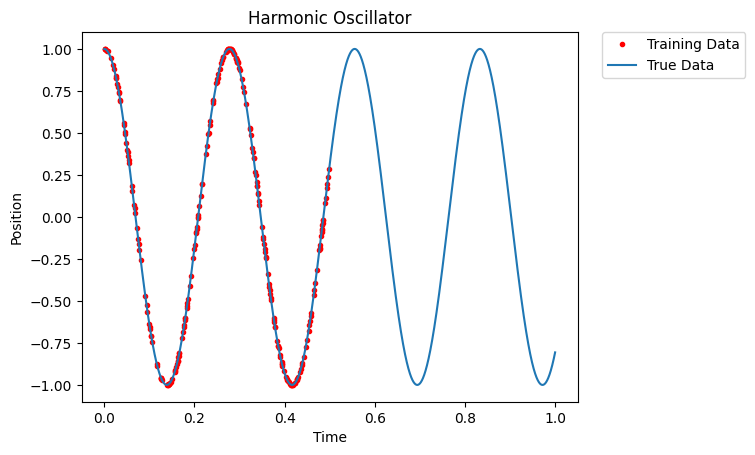

In [3]:
# Generate training data from the first half of the true_data_dict
sample_size = 250
true_data_the_first_half = dict(list(true_data.items())[:int(len(true_data)/2)]) # first half of the true_data_dict
training_dict = dict(random.sample(true_data_the_first_half.items(), sample_size)) # randomly select 10 data points from the first half of the true_data_dict

training_time = list(training_dict.keys()) # convert the keys of the training_dict to a list
training_position = list(training_dict.values()) # convert the values of the training_dict to a list

# Plot the results:
import matplotlib.pyplot as plt
plt.plot(training_time, training_position, "ro", label="Training Data", markersize=3)
plt.plot(true_data.keys(), true_data.values(), label="True Data")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) # move legend to outside of figure
plt.xlabel("Time")
plt.ylabel("Position")
plt.title("Harmonic Oscillator")
plt.show()


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

# model
class Net(nn.Module):
    def __init__(self, hidden_size=32):
        super(Net, self).__init__()
        self.linear_input = nn.Linear(1, hidden_size)  # input layer

        self.linear_1 = nn.Linear(hidden_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, hidden_size)

        self.linear_output = nn.Linear(hidden_size, 1) # output layer
        

    def forward(self, x):
        x = torch.tanh(self.linear_input(x))

        x = torch.tanh(self.linear_1(x))
        x = torch.tanh(self.linear_2(x))
        x = torch.tanh(self.linear_3(x))

        x = self.linear_output(x)
        return x

# Create an instance of the neural network
model = Net(hidden_size=32)

In [20]:


# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs =  10000

losses_total = []
losses_data = []
losses_physics = []

# Convert the training data to tensors
training_time_tensor = torch.tensor(training_time, dtype=torch.float32)
training_position_tensor = torch.tensor(training_position, dtype=torch.float32)

# Randomly select 100 data points from the data for physics loss
training_time_physics_tensor = torch.tensor(sorted(random.sample(true_data.items(), 100)), dtype=torch.float32).view(-1, 1)

#training_time_physics_tensor = torch.linspace(0,1,100).view(-1,1).requires_grad_(True)


batch_size = 250
point_zero = torch.tensor([0.0], dtype=torch.float32).requires_grad_(True)


# Create a DataLoader to handle batching and shuffling
dataset = TensorDataset(training_time_tensor, training_position_tensor)

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()  # Zero the gradients

    losses_total = []
    losses_data = []
    losses_physics = []

    for batch in data_loader:
        batch_time, batch_position = batch
        batch_time, batch_position = batch_time.requires_grad_(True).view(-1, 1), batch_position.requires_grad_(True).view(-1, 1)

        ##################################################################################
        # Calculate the data loss
        data_outputs = model(batch_time)  # Reshape and then forward pass
        data_loss = criterion(data_outputs, batch_position)  # Compute the loss

        ##################################################################################
        # Calculate the physics loss
        # physics_outputs = model(training_time_physics_tensor.requires_grad_(True))
        # dx = torch.autograd.grad(physics_outputs, training_time_physics_tensor.requires_grad_(True), torch.ones_like(physics_outputs), create_graph=True)[0]  # first derivative
        # ddx = torch.autograd.grad(dx, training_time_physics_tensor.requires_grad_(True), torch.ones_like(dx), create_graph=True)[0]  # second derivative
        # For a single batch
        physics_outputs = model(batch_time)
        dx = torch.autograd.grad(physics_outputs, batch_time, torch.ones_like(physics_outputs), create_graph=True)[0]
        ddx = torch.autograd.grad(dx, batch_time, torch.ones_like(dx), create_graph=True)[0]

        physics_informed_value_loss = (ddx + ((k / m) * physics_outputs)) ** 2

        # initial_condition_loss = (physics_outputs[0] - x_0) ** 2
        # initial_velocity_condition_loss = (dx[0] - p_0 / m) ** 2  # p = mv
        # Initial condition loss applies at point t=0
        initial_outputs = model(point_zero)
        initial_condition_loss = (initial_outputs - x_0) ** 2
        initial_velocity_outputs = torch.autograd.grad(initial_outputs, point_zero, torch.ones_like(initial_outputs), create_graph=True)[0]
        initial_velocity_condition_loss = (initial_velocity_outputs - p_0 / m) ** 2

        # min and max condition
        # Since we don't know the exact value at the boundary (at t = 1), I just use the info about the min and max value

        min_condition_loss = (torch.min(physics_outputs) - (-1)) ** 2
        max_condition_loss = (torch.max(physics_outputs) - (1)) ** 2

        # physics_loss = (torch.mean(physics_informed_value_loss + initial_condition_loss + initial_velocity_condition_loss + min_condition_loss + max_condition_loss)) * 0.0001
        physics_loss = (torch.mean(physics_informed_value_loss*1e-1 + initial_condition_loss*3e2 + initial_velocity_condition_loss*3e2))

        ##################################################################################
        # Calculate the total loss
        total_loss = physics_loss
        total_loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights

        losses_total.append(total_loss.item())
        losses_data.append(data_loss.item())
        losses_physics.append(physics_loss.item())

    # Compute and print the average loss for the epoch
    avg_total_loss = np.mean(losses_total)
    avg_data_loss = np.mean(losses_data)
    avg_physics_loss = np.mean(losses_physics)

    # print(f"Epoch {epoch+1}/{num_epochs}, Avg. Total Loss: {avg_total_loss}, Avg. Data Loss: {avg_data_loss}, Avg. Physics Loss: {avg_physics_loss}")

100%|██████████| 10000/10000 [01:11<00:00, 139.70it/s]


Final loss: 7.057431697845459


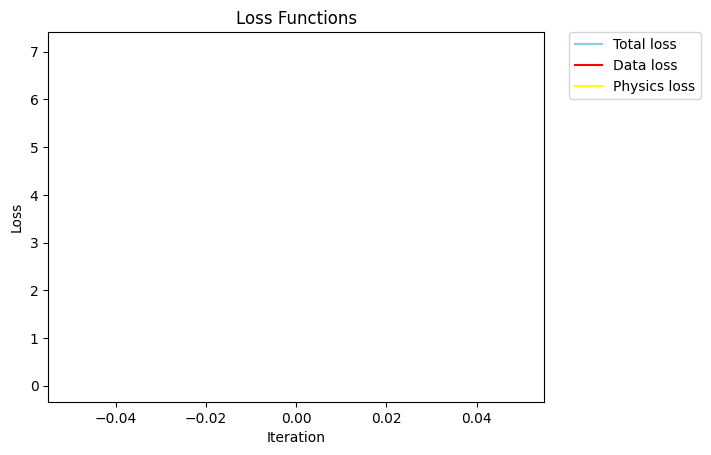

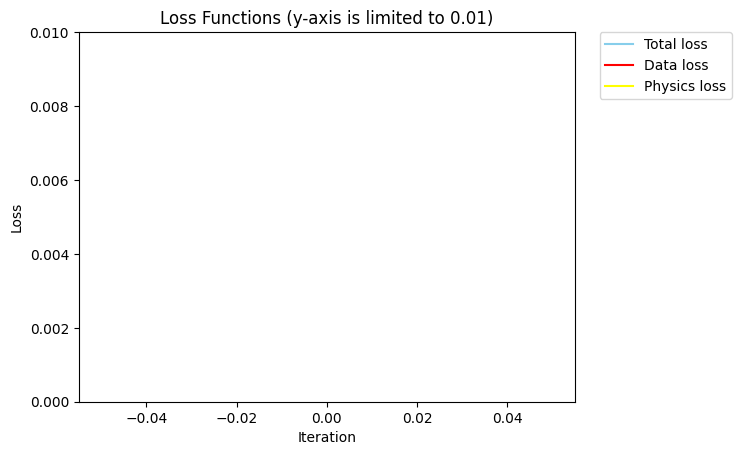

In [21]:
# Print the final loss
print('Final loss:', total_loss.item())

# Plot the loss curves
plt.plot(losses_total, label='Total loss', color='skyblue')
plt.plot(losses_data, label='Data loss', color='red')
plt.plot(losses_physics, label='Physics loss', color='yellow')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title("Loss Functions")
plt.show()

# plot the same figure in log scale
plt.plot(losses_total, label='Total loss', color='skyblue')
plt.plot(losses_data, label='Data loss', color='red')
plt.plot(losses_physics, label='Physics loss', color='yellow')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title("Loss Functions (y-axis is limited to 0.01)")
plt.ylim(0, 0.01)
plt.show()

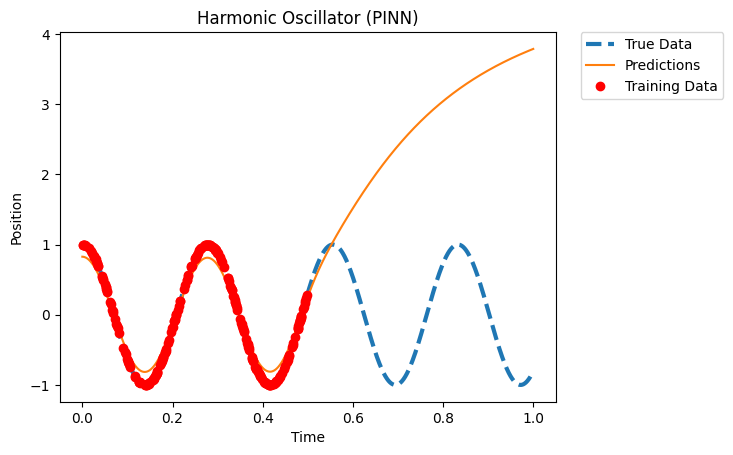

In [23]:
import torch
import matplotlib.pyplot as plt
import numpy as np


test_time = torch.tensor(true_time, dtype=torch.float32).view(-1, 1)

# Use the trained model to predict test positions
with torch.no_grad():
    test_predictions = model(test_time)


# Plot the results
plt.plot(true_data.keys(), true_data.values(), label="True Data", linewidth=3, linestyle='dashed')
plt.plot(true_time, test_predictions, label = "Predictions") 
plt.plot(training_time, training_position, "ro", label="Training Data", markersize=6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel("Time")
plt.ylabel("Position")
plt.title("Harmonic Oscillator (PINN)")
plt.show()

In [8]:
# Use the same model and training data as above but do not calculate the physics loss

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

# model
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.linear_input = nn.Linear(1, 32)  # input layer

        self.linear_1 = nn.Linear(32, 32)
        self.linear_2 = nn.Linear(32, 32)
        self.linear_3 = nn.Linear(32, 32)

        self.linear_output = nn.Linear(32, 1) # output layer
        

    def forward(self, x):
        x = torch.tanh(self.linear_input(x)) 

        x = torch.tanh(self.linear_1(x))
        x = torch.tanh(self.linear_2(x))
        x = torch.tanh(self.linear_3(x))

        x = self.linear_output(x) 
        return x

# Create an instance of the neural network
model2 = Net2()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.0001)  # Adam optimizer

# Training loop
num_epochs =  100000

losses_total = []
losses_data = []

# Convert the training data to tensors
training_time_tensor = torch.tensor(training_time, dtype=torch.float32)
training_position_tensor = torch.tensor(training_position, dtype=torch.float32)

for epoch in range(num_epochs):
    
    optimizer.zero_grad()  # Zero the gradients

    ##################################################################################
    # Calculate the data loss
    data_outputs = model2(training_time_tensor.view(-1, 1) )  # Reshape and then forward pass
    data_loss = criterion(data_outputs, training_position_tensor.view(-1, 1))  # Compute the loss

    ##################################################################################
    # Calculate the total loss
    """total_loss = data_loss + physics_loss"""
    total_loss = data_loss
    total_loss.backward()  # Backpropagation
    optimizer.step()  # Update the weights
    
    ##################################################################################
    # Save the losses for plotting
    losses_total.append(total_loss.item())
    losses_data.append(data_loss.item())



test_time = torch.tensor(true_time, dtype=torch.float32).view(-1, 1)

# Use the trained model to predict test positions
with torch.no_grad():
    test_predictions = model2(test_time)


# Plot the results
plt.plot(true_data.keys(), true_data.values(), label="True Data", linewidth=3, linestyle='dashed')
plt.plot(true_time, test_predictions, label = "Predictions") 
plt.plot(training_time, training_position, "ro", label="Training Data", markersize=6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel("Time")
plt.ylabel("Position")
plt.title("Harmonic Oscillator (No Physics Loss)")
plt.show()                                                                     

KeyboardInterrupt: 